<a href="https://colab.research.google.com/github/Kristelwen/TM10007_PROJECT/blob/master/brat_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment
Kristel, Lalot, Marijn, Tahisa

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/Kristelwen/TM10007_PROJECT

# Data loading and importing modules

In [0]:
# Importing modules
# General packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from time import time
from sklearn import datasets as ds
from scipy.stats import randint

# Preprocessing packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

# SVM Kernels
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.decomposition import KernelPCA

# Model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

# Performance metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

# Regularization
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.feature_selection import SelectFromModel

In [4]:
# Loading the data
from brats.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 167
The number of columns: 725


In [0]:
data_top = data.head()  

# display  
# data_top 

# Preprocessing

In [0]:
# Drop columns which contain NaN values
threshold = math.floor(len(data)/2)  # calculate threshold, half of total rows
data_drop = data.dropna(thresh=threshold, axis=1)  # Delete columns/features with more than 'threshold' NaNs
data_drop = data_drop.dropna(axis=0)  # Delete rows/subjects with NaNs

# Split data and labels
labels = data_drop['label']
data_drop = data_drop.drop(columns="label")  # Data without labels

# Convert labels 'GBM' and 'LGG' to respectively 0 and 1
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the data in a train (90%) and test set (10%)
data_train, data_test, label_train, label_test = train_test_split(data_drop, labels, test_size=0.1)
data_train2, data_val, label_train2, label_val = train_test_split(data_train, label_train, test_size=0.1)

# Feature scaling
scaler = RobustScaler()
transformer = scaler.fit(data_train2.values)  # Fit on training data 2
data_scaled_train2 = transformer.transform(data_train2.values)
data_df_train2 = pd.DataFrame(data_scaled_train2, index = data_train2.index, columns = data_train2.columns)

data_scaled_val = transformer.transform(data_val.values)
data_df_val = pd.DataFrame(data_scaled_val, index = data_val.index, columns = data_val.columns)

data_scaled_test = transformer.transform(data_test.values)
data_df_test = pd.DataFrame(data_scaled_test, index = data_test.index, columns = data_test.columns)

scaler2 = RobustScaler()
transformer2 = scaler2.fit(data_train.values)  # Fit on training data 1
data_scaled_train = transformer2.transform(data_train.values)
data_df_train = pd.DataFrame(data_scaled_train, index = data_train.index, columns = data_train.columns)

# Feature selection: PCA
  # Training set 2
pca_train = PCA(n_components=80)  # Create a PCA with 20 components
pca_train.fit(data_scaled_train2)  # Fit PCA
data_train_pca2 = pca_train.transform(data_scaled_train2)  # Transform train data using PCA
#df_train_pca2 = pd.DataFrame(data_train_pca2, index = data_scaled_train2.index)  # Put train data back in dataframe with 20 most important features
 
  # Training set 1
data_train_pca = pca_train.transform(data_train)
  # Validatie set
data_val_pca = pca_train.transform(data_scaled_val)  # Transform test data using PCA
  # Test set
data_test_pca = pca_train.transform(data_scaled_test)  # Transform test data using PCA


# Classifiers

## Ridgen

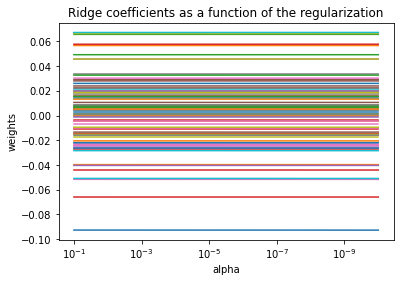

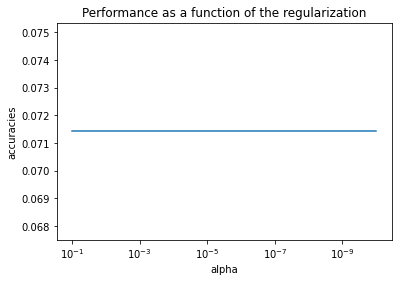

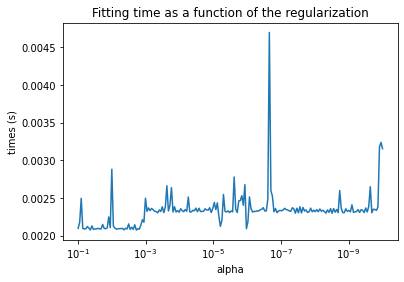

In [0]:
# Display the weights and compute error for multiple values for alpha
n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)

# Construct classifiers
coefs = []
accuracies = []
times = []
for a in alphas:
    # Fit classifier
    clf = RidgeClassifier(alpha=a, fit_intercept=False)
    t0 = time()
    clf.fit(data_train_pca, label_train)
    duration = time() - t0
    val_pred = clf.predict(data_val_pca)
    message = ("\t Misclassified: %d / %d" % ((label_validation != val_pred).sum(), label_validation.shape[0]))
    # print(message)
    
    # Append statistics
    accuracy = float((label_validation != val_pred).sum()) / float(label_validation.shape[0])
    times.append(duration)
    accuracies.append(accuracy)
    coefs.append(clf.coef_)

# #############################################################################
# Display results

# Weights
plt.figure()
ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Performance
plt.figure()
ax = plt.gca()
ax.plot(alphas, accuracies)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('accuracies')
plt.title('Performance as a function of the regularization')
plt.axis('tight')
plt.show()

# Times
plt.figure()
ax = plt.gca()
ax.plot(alphas, times)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('times (s)')
plt.title('Fitting time as a function of the regularization')
plt.axis('tight')
plt.show()


## Random Forest Classifier with PCA
Zoals ik het nu heb aangepast kan denk ik blokje 6, 20 en 21 weg. Zijn jullie het hiermee eens? Heb de accuracy op de nette manier berekend ook nu. En random forest niet meer gefit op de validatie set.

In [6]:
# IK (KRISTEL) DENK DAT DIT HELE BLOKJE WEG KAN, EVEN CHECKEN !! -> CHECKEN VOOR BOOTSTRAP KOMT IN HYPERPARAMETER OPTIMIZATION OOK NAAR VOREN
#default settings 
n_samples=len(data_val_pca)
homemade_random_forest = BaggingClassifier(RandomForestClassifier()) 
homemade_random_forest.fit(data_train_pca,label_train) #fit the classifier on the training set 
test=homemade_random_forest.predict(data_val_pca) #test 
error= (sum(abs(test - label_val))/n_samples)*100
error = (round(error, 2))
print ('the error when using default settings is {}%'.format(error))

print ('')

#using different n_trees and bootstrapping  
n_trees=[5,10,50,100,150,200,300,400,500,600]
for n_tree in n_trees:
  clf = RandomForestClassifier(n_estimators=n_tree, bootstrap=True)
  clf.fit(data_train_pca2,label_train2)
  
  predictions_train = clf.predict(data_train_pca2)
  errors_train = (sum(abs(predictions_train - label_train2))/n_samples)*100
  errors_train = (round(errors_train, 2))
  
  print ('Train set: When using bootstrapping and {} trees, the error is {}%'.format(n_tree,errors_train))

  predictions_val = clf.predict(data_val_pca)
  errors_val = (sum(abs(predictions_val - label_val))/n_samples)*100
  errors_val = (round(errors_val, 2))

  print ('Validation set: When using bootstrapping and {} trees, the error is {}%'.format(n_tree,errors_val))

print ('')

#using different n_trees without bootstrapping  
n_trees=[5,10,50,100,150,200,300,400,500,600]
for n_tree in n_trees:
  clf = RandomForestClassifier(n_estimators=n_tree, bootstrap=False)
  clf.fit(data_train_pca2,label_train2)
  
  predictions_train = clf.predict(data_train_pca2)
  errors_train = (sum(abs(predictions_train - label_train2))/n_samples)*100
  errors_train = (round(errors_train, 2))
  
  print ('Train set: Without bootstrapping and {} trees, the error is {}%'.format(n_tree,errors_train))

  predictions_val = clf.predict(data_val_pca)
  errors_val = (sum(abs(predictions_val - label_val))/n_samples)*100
  errors_val = (round(errors_val, 2))

  print ('Validation set: Without bootstrapping and {} trees, the error is {}%'.format(n_tree,errors_val))

the error when using default settings is 14.29%

Train set: When using bootstrapping and 5 trees, the error is 7.14%
Validation set: When using bootstrapping and 5 trees, the error is 35.71%
Train set: When using bootstrapping and 10 trees, the error is 21.43%
Validation set: When using bootstrapping and 10 trees, the error is 35.71%
Train set: When using bootstrapping and 50 trees, the error is 0.0%
Validation set: When using bootstrapping and 50 trees, the error is 14.29%
Train set: When using bootstrapping and 100 trees, the error is 0.0%
Validation set: When using bootstrapping and 100 trees, the error is 21.43%
Train set: When using bootstrapping and 150 trees, the error is 0.0%
Validation set: When using bootstrapping and 150 trees, the error is 14.29%
Train set: When using bootstrapping and 200 trees, the error is 0.0%
Validation set: When using bootstrapping and 200 trees, the error is 14.29%
Train set: When using bootstrapping and 300 trees, the error is 0.0%
Validation set: W

In [7]:
# Hyperparameter optimization of Random Forest Classifier

# Our parameter to optimize is the number of estimators, which we vary uniformly between 1 and 400
param_distributions = {'n_estimators': randint(1, 400)}
    
# Execute RandomizedSearchCV to find optimal parameters
clf_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions, cv=5, n_iter=20, random_state=42)

# Fit the classifier
clf_rf.fit(data_train_pca2, label_train2)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [8]:
# Get the best estimator and best parameters belonging to that estimator
print(f'\n The best estimator is {clf_rf.best_estimator_} \n The best amount of trees is {clf_rf.best_params_}')


 The best estimator is RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=103,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
 The best amount of trees is {'n_estimators': 103}


In [20]:
# KAN DENK IK WEG!
#Random Forest classifier as a function 
def RandomForest(n_trees,data_train_pca2,data_val_pca,labels_train2,labels_val):
  clf = RandomForestClassifier(n_estimators=n_trees, bootstrap=True)
  clf.fit(data_train_pca2,label_train2)
  predictions_train = clf.predict(data_train_pca2)
  acc_train = accuracy_score(label_train2, predictions_train)

  # acc/error op Beun manier WEGHALEN?!
  # n_samples=len(data_train_pca2)
  # errors_train = (sum(abs(predictions_train - label_train2))/n_samples)*100
  # errors_train = (round(errors_train, 2))
  # accuracy_train=100-errors_train

  # clf.fit(data_val_pca,label_val)  # DEZE REGEL WEGGEHAALD WANT JE MOET NIET FITTEN OP VALIDATIE?
  predictions_val = clf.predict(data_val_pca)
  acc_val = accuracy_score(label_val, predictions_val)

  # Acc/error op Beun manier WEGHALEN?!
  # n_samples=len(data_val_pca)
  # errors_val = (sum(abs(predictions_val - label_val))/n_samples)*100
  # errors_val = (round(errors_val, 2))
  # accuracy_val=100-errors_val

  return (acc_train, acc_val)

# Evaluate accuracy of random forest on training and validation set
acc = RandomForest(15,data_train_pca2,data_val_pca,label_train2,label_val)

print(f'Accuracy of Random Forest Classifier for the training set is {acc[0]} and for the validation set is {acc[1]}')


Accuracy of Random Forest Classifier for the training set is 1.0 and for the validation set is 0.7142857142857143


In [26]:
# DIT STUK IPV DE 2 BLOKJES HIERBOVEN?!
# Fitting the Random Forest classifier
n_trees = 15
RF = RandomForestClassifier(n_estimators=n_trees, bootstrap=True)
RF.fit(data_train_pca2, label_train2)

# Predictions
train2_pred_RF = RF.predict(data_train_pca2)
val_pred_RF = RF.predict(data_val_pca)
train_pred_RF = RF.predict(data_train_pca)
test_pred_RF = RF.predict(data_test_pca)

# Evaluate accuracy of Random Forest Classifier on training set
acc_train_RF = accuracy_score(label_train2, train2_pred_RF)
print(f'\n The accuracy of the training set is {acc_train_RF}')

# Evaluate accuracy of Random Forest Classifier on validation set
acc_val_RF = accuracy_score(label_val, val_pred_RF)
print(f'\n The accuracy of the validation set is {acc_val_RF}')

# Evaluate accuracy of Random Forest Classifier on test set
acc_test_RF = accuracy_score(label_test, test_pred_RF)
print(f'\n The accuracy of the test set is {acc_test_RF}')



 The accuracy of the training set is 1.0

 The accuracy of the validation set is 0.8571428571428571

 The accuracy of the test set is 0.8666666666666667


In [21]:
# KAN DENK IK WEG?!
# Evaluate accuracy of random forest 
predictions_test = clf.predict(data_test_pca)
n_samples=len(data_test_pca)
errors_test = (sum(abs(predictions_test - label_test))/n_samples)*100
errors_test = (round(errors_test, 2))
accuracy_test=100-errors_test

print(f'Accuracy of Random Forest Classifier for the test set is {accuracy_test}')

Accuracy of Random Forest Classifier for the test set is 86.67


## Random forest with feature_importances_

Feature ranking:


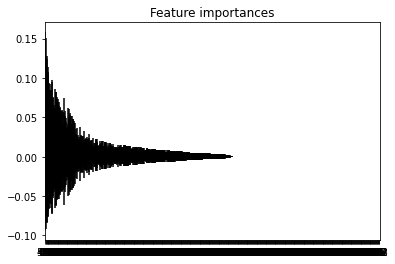

              VOLUME_ET  VOLUME_NET  ...  TGM_Cog_Y_1   TGM_T_1
ID                                   ...                       
TCGA-76-6664  -0.192073   -0.341534  ...    -1.300943 -0.447847
TCGA-HT-7690  -0.007164    4.505023  ...    -0.794279  1.479518
TCGA-HT-8111  -0.474489   -0.420584  ...    -0.813479 -0.781609
TCGA-02-0085   0.254606   -0.316455  ...    -0.514006 -0.121796
TCGA-06-0137   1.021397   -0.172802  ...     0.897209  0.255732
...                 ...         ...  ...          ...       ...
TCGA-19-5954  -0.080364   -0.217093  ...     0.630053 -0.383578
TCGA-02-0047   1.042106    0.000000  ...     0.313475 -0.011195
TCGA-14-1794   1.501423    1.470411  ...    -0.813735  0.982596
TCGA-06-1084   0.261801   -0.362176  ...    -0.136651  0.014476
TCGA-06-0142   1.031908   -0.115458  ...    -0.260002  0.455674

[117 rows x 395 columns]


In [0]:
# Feature importances
forest = RandomForestClassifier(n_estimators=100, bootstrap=True)

forest.fit(data_df_train2, label_train2)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# for f in range(data_df_train2.shape[1]):
    # print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(data_df_train2.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data_df_train2.shape[1]), indices)
plt.xlim([-1, data_df_train2.shape[1]])
plt.show()

# Only keep features with importance > 0.00
mask = importances > 0
mask2 = data_df_train2.columns[mask]
data_train2_selection = data_df_train2[mask2]
print(data_train2_selection)

In [0]:
#default settings 
n_samples=len(data_scaled_val)
# BaggingClassifier().coef_ = BaggingClassifier().feature_importances_
homemade_random_forest = BaggingClassifier(RandomForestClassifier()) 
# homemade_random_forest.coef_ = homemade_random_forest.feature_importances_
selector = RFECV(homemade_random_forest, step=1, cv=5)
selector = selector.fit(data_df_train2, label_train2)
selector.support_
print(selector.ranking_)


homemade_random_forest.fit(data_scaled_train2,label_train2) #fit the classifier on the training set 
test=homemade_random_forest.predict(data_scaled_val) #test 
error= (sum(abs(test - label_val))/n_samples)*100
error = (round(error, 2))
print ('the error when using default settings is {}%'.format(error))

print ('')#  ff voor overzicht 

#using different n_trees and bootstrapping  
n_trees=[5,10,50,100,150,200,300,400,500,600]
for n_tree in n_trees:
  clf = RandomForestClassifier(n_estimators=n_tree, bootstrap=True)
  clf.fit(data_scaled_train2, label_train2)
  
  predictions_train = clf.predict(data_scaled_train2)
  errors_train = (sum(abs(predictions_train - label_train2))/n_samples)*100
  errors_train = (round(errors_train, 2))
  
  print ('Train set: When using bootstrapping and {} trees, the error is {}%'.format(n_tree,errors_train))

  predictions_val = clf.predict(data_scaled_val)
  errors_val = (sum(abs(predictions_val - label_val))/n_samples)*100
  errors_val = (round(errors_val, 2))

  print ('Validation set: When using bootstrapping and {} trees, the error is {}%'.format(n_tree,errors_val))

print ('')

#using different n_trees without bootstrapping  
n_trees=[5,10,50,100,150,200,300,400,500,600]
for n_tree in n_trees:
  clf = RandomForestClassifier(n_estimators=n_tree, bootstrap=False)
  clf.fit(data_scaled_train2,label_train2)
  
  predictions_train = clf.predict(data_scaled_train2)
  errors_train = (sum(abs(predictions_train - label_train2))/n_samples)*100
  errors_train = (round(errors_train, 2))
  
  print ('Train set: Without bootstrapping and {} trees, the error is {}%'.format(n_tree,errors_train))

  predictions_val = clf.predict(data_scaled_val)
  errors_val = (sum(abs(predictions_val - label_val))/n_samples)*100
  errors_val = (round(errors_val, 2))

  print ('Validation set: Without bootstrapping and {} trees, the error is {}%'.format(n_tree,errors_val))

RuntimeError: ignored

## Hyperparameter optimization of Random Forest Classifier

In [0]:
# Our parameter to optimize is the number of estimators, which we vary uniformlybetween 1 and 400
param_distributions = {'n_estimators': randint(1, 400)}

# Now use the classifiers on all datasets
fitted_clfs = list()
    
# Within a 5-fold cross-validation, try out 20 different number of trees
clf = RandomizedSearchCV(RandomForestClassifier(), param_distributions, cv=5, n_iter=20, random_state=42)

# Fit the classifier
clf.fit(data_scaled_train2, label_train2)

# Save for next part
fitted_clfs.append(clf)

In [0]:
# Get the best estimator and best parameters belonging to that estimator
print(f'\n The best estimator is {clf.best_estimator_} \n The best amount of trees is {clf.best_params_}')


 The best estimator is RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=271,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
 The best amount of trees is {'n_estimators': 271}


In [0]:
#Random Forest classifier as a function 
def RandomForest(n_trees,data_scaled_train,data_scaled_val,labels_train2,labels_val):
  clf = RandomForestClassifier(n_estimators=n_trees, bootstrap=True)
  clf.fit(data_scaled_train2,label_train2)
  predictions_train = clf.predict(data_scaled_train2)
  n_samples=len(data_scaled_train2)
  errors_train = (sum(abs(predictions_train - label_train2))/n_samples)*100
  errors_train = (round(errors_train, 2))
  accuracy_train=100-errors_train

  clf.fit(data_scaled_val,label_val)
  predictions_val = clf.predict(data_scaled_val)
  n_samples=len(data_scaled_val)
  errors_val = (sum(abs(predictions_val - label_val))/n_samples)*100
  errors_val = (round(errors_val, 2))
  accuracy_val=100-errors_val

  return (accuracy_train, accuracy_val)

acc = RandomForest(15,data_scaled_train2,data_scaled_val,label_train2,label_val)
print(f'Accuracy of Random Forest Classifier for the training set is {acc[0]} and for the validation set is {acc[1]}')

Accuracy of Random Forest Classifier for the training set is 99.15 and for the validation set is 100.0


In [0]:
predictions_test = clf.predict(data_scaled_test)
n_samples=len(data_scaled_test)
errors_test = (sum(abs(predictions_test - label_test))/n_samples)*100
errors_test = (round(errors_test, 2))
accuracy_test=100-errors_test

print(f'Accuracy of Random Forest Classifier for the test set is {accuracy_test}')

Accuracy of Random Forest Classifier for the test set is 86.67


## Support Vector Machine with PCA

In [0]:
#Construct classifiers
svmlin = SVC(kernel='linear', gamma='scale') # linear kernel 
svmrbf = SVC(kernel='rbf', gamma='scale') # radial basis function kernel 
svmpoly = SVC(kernel='poly', degree=3, gamma='scale') # polynomial kernel

clsfs = [svmlin, svmrbf, svmpoly]

# for clf in clsfs: # voor alle classifiers in lijst
#    clf.fit(data_train_pca2, label_train2) # fit classifier op trainingsset
#    val = clf.predict(data_val) # test classifier op testset
#    error = (sum(abs(val - label_val))/len(data_val))*100 # hoevaak fout? 
#    error = (round(error, 2))
#    accuracy = 100 - error
    # print(f'The Accuracy of SVM is {accuracy}%')

# functie
def SVM(clsfs, data_df_train2, data_df_val, label_train2, label_val): 
    accuracies_train = list()
    accuracies_val = list()

    for clf in clsfs:
      clf.fit(data_df_train2,label_train2)
      predictions_train = clf.predict(data_df_train2)
      n_samples=len(data_df_train2)
      errors_train = (sum(abs(predictions_train - label_train2))/n_samples)*100
      errors_train = (round(errors_train, 2))
      accuracy_train=100-errors_train
      accuracies_train.append(accuracy_train)
      
      clf.fit(data_df_val,label_val)
      predictions_val = clf.predict(data_df_val)
      n_samples=len(data_df_val)
      errors_val = (sum(abs(predictions_val - label_val))/n_samples)*100
      errors_val = (round(errors_val, 2))
      accuracy_val=100-errors_val
      accuracies_val.append(accuracy_val)

    return (accuracies_train, accuracies_val)

accuracies_train, accuracies_val = SVM(clsfs, data_train_pca2, data_val_pca, label_train2, label_val)

clsfs_names = ['SVM with linear kernel', 'SVM with radial basis function kernel', 'SVM with polynomial kernel']
for num, acc_train in enumerate(accuracies_train):
    print(f'\n The accuracy of {clsfs_names[num]} is {acc_train}% for the train set and {accuracies_val[num]}% for the validation set')



 The accuracy of SVM with linear kernel is 100.0% for the train set and 100.0% for the validation set

 The accuracy of SVM with radial basis function kernel is 67.52000000000001% for the train set and 92.86% for the validation set

 The accuracy of SVM with polynomial kernel is 67.52000000000001% for the train set and 92.86% for the validation set


## Hyperparameters SVM

In [0]:
# Parameters
degrees = randint(1, 5)
coef0s = [1, 0.5, 0.01]
slacks = [0.1,1, 10, 100]
gammas = [1, 0.1 ,0.01, 0.001]
kernels = ['linear', 'rbf', 'poly']

# Creating paramater space
param_grid = {'degree': degrees,'coef0': coef0s, 'C': slacks, 'gamma': gammas, 'kernel': kernels}

# Searching for best parameters
SVM = RandomizedSearchCV(SVC(),param_grid,cv=5, random_state=42, return_train_score=True)
# Fitting classifier on training set
SVM.fit(data_train_pca2, label_train2)

# Predict parameters
train2_pred = SVM.predict(data_train_pca2)
val_pred = SVM.predict(data_val_pca)
# train_pred = SVM.predict(data_train_pca)
test_pred = SVM.predict(data_test_pca)

# Calculating scores
folds = 3
score = cross_val_score(SVM.best_estimator_, data_df_train, label_train, cv=folds)  # Train set
mean_score = score.mean()

# Print final best estimator and accuracies
# Best estimator
print("\n###############################################################")
print(f'\n The best estimator is {SVM.best_estimator_} \n \n The best settings are {SVM.best_params_}\n')
print("###############################################################\n")


# Confusion matrix and classification report
print('Confusion matrix and classification report of training set')
print(confusion_matrix(label_train2, train2_pred))
print(classification_report(label_train2, train2_pred))
print("---------------------------------------------------------------\n")

print('Confusion matrix and classification report of validation set')
print(confusion_matrix(label_val, val_pred))
print(classification_report(label_val, val_pred))
print("---------------------------------------------------------------\n")

print('Confusion matrix and classification report of test set')
print(confusion_matrix(label_test, test_pred))
print(classification_report(label_test, test_pred))

# Accuracy of Validation set:
print("\n###############################################################\n")
print(f'\n The accuracy of the validation set in the n={folds} different folds is {score}')
print(f'\n The mean accuracy of the validation set of n={folds} different folds is {mean_score}')
print("\n###############################################################\n")

# Evaluate SVM on training set
acc_train = accuracy_score(label_train2, train2_pred)
print(f'\n The accuracy of the training set is {acc_train}')

# Evaluate SVM on validation set
acc_val = accuracy_score(label_val, val_pred)
print(f'\n The accuracy of the validation set is {acc_val}')

# Evaluate SVM on test set
acc_test = accuracy_score(label_test, test_pred)
print(f'\n The accuracy of the test set is {acc_test}')


###############################################################

 The best estimator is SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 
 
 The best settings are {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'linear'}

###############################################################

Confusion matrix and classification report of training set
[[83  0]
 [ 0 34]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00        34

    accuracy                           1.00       117
   macro avg       1.00      1.00      1.00       117
weighted avg       1.00      1.00      1.00       117

---------------------------------------------------------------

Confusion matrix and classificat

## Neural Networks

In [27]:
# Hyperparameter optimization of Neural Network

# Define parameter space that needs to be optimized
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (7,2), (7,7,7),(9,9,9,9),(50,50,50,50), (50,50,50,50,50)],
    'activation': ['logistic','identity','tanh'], 
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
    
# Execute RandomizedSearchCV to find optimal parameters
clf_mlp = RandomizedSearchCV(MLPClassifier(max_iter=2000), parameter_space, cv=5, random_state=42, return_train_score=True)  # Verbose=2 & refit=True uitzoeken

# Fit the classifier
clf_mlp.fit(data_train, label_train)

# Get the best parameters for the MLP estimator
print('Best parameters found:\n', clf_mlp.best_params_)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:768: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:768: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/loc

Best parameters found:
 {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (7, 7, 7), 'alpha': 0.05, 'activation': 'identity'}


In [0]:
# Plot the dataframe of the hyperparameter optimization
pd.DataFrame(clf_mlp.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_learning_rate,param_hidden_layer_sizes,param_alpha,param_activation,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.299022,0.271891,0.004074,0.000240,adam,constant,"(7, 2)",0.05,logistic,"{'solver': 'adam', 'learning_rate': 'constant'...",0.703704,0.692308,0.692308,0.307692,0.692308,0.617664,0.155049,9,0.692308,0.695238,0.695238,0.304762,0.695238,0.616557,0.155902
1,2.478899,1.135125,0.004381,0.000071,sgd,constant,"(100,)",0.0001,tanh,"{'solver': 'sgd', 'learning_rate': 'constant',...",0.740741,0.730769,0.692308,0.769231,0.769231,0.740456,0.028524,2,0.875000,0.828571,0.695238,0.847619,0.876190,0.824524,0.067055
2,2.187029,0.024433,0.004357,0.000265,sgd,constant,"(7, 2)",0.0001,identity,"{'solver': 'sgd', 'learning_rate': 'constant',...",0.703704,0.692308,0.692308,0.692308,0.692308,0.694587,0.004558,3,0.692308,0.695238,0.695238,0.695238,0.695238,0.694652,0.001172
3,0.109056,0.051416,0.004101,0.000178,adam,adaptive,"(7, 2)",0.0001,tanh,"{'solver': 'adam', 'learning_rate': 'adaptive'...",0.333333,0.192308,0.307692,0.692308,0.692308,0.443590,0.208561,10,0.490385,0.380952,0.466667,0.695238,0.742857,0.555220,0.139447
4,1.718686,0.424521,0.004168,0.000063,adam,constant,"(7, 7, 7)",0.05,identity,"{'solver': 'adam', 'learning_rate': 'constant'...",0.777778,0.807692,0.769231,0.730769,0.769231,0.770940,0.024564,1,0.884615,0.923810,0.942857,0.942857,0.971429,0.933114,0.028624
5,0.111279,0.041251,0.004158,0.000114,adam,constant,"(7, 7, 7)",0.05,tanh,"{'solver': 'adam', 'learning_rate': 'constant'...",0.740741,0.692308,0.692308,0.653846,0.692308,0.694302,0.027587,7,0.615385,0.695238,0.714286,0.695238,0.704762,0.684982,0.035508
6,0.219620,0.142995,0.004013,0.000146,adam,adaptive,"(7, 2)",0.0001,logistic,"{'solver': 'adam', 'learning_rate': 'adaptive'...",0.703704,0.692308,0.692308,0.692308,0.692308,0.694587,0.004558,3,0.692308,0.695238,0.695238,0.695238,0.695238,0.694652,0.001172
7,0.185261,0.109540,0.004246,0.000157,sgd,adaptive,"(7, 7, 7)",0.0001,logistic,"{'solver': 'sgd', 'learning_rate': 'adaptive',...",0.703704,0.692308,0.692308,0.692308,0.692308,0.694587,0.004558,3,0.692308,0.695238,0.695238,0.695238,0.695238,0.694652,0.001172
8,0.220436,0.104478,0.004046,0.000098,sgd,constant,"(7, 7, 7)",0.0001,logistic,"{'solver': 'sgd', 'learning_rate': 'constant',...",0.703704,0.692308,0.692308,0.692308,0.692308,0.694587,0.004558,3,0.692308,0.695238,0.695238,0.695238,0.695238,0.694652,0.001172
9,0.354048,0.037892,0.004274,0.000095,adam,constant,"(100,)",0.0001,logistic,"{'solver': 'adam', 'learning_rate': 'constant'...",0.629630,0.692308,0.692308,0.615385,0.692308,0.664387,0.034491,8,0.730769,0.685714,0.695238,0.695238,0.714286,0.704249,0.016186


In [0]:
# Fitting the Neural Network Classifier with optimal hyperparameters
MLP = MLPClassifier(solver='adam', learning_rate='constant',hidden_layer_sizes=(9,9,9,9), alpha=0.0001, activation='identity')
MLP.fit(data_df_train2, label_train2)

# Predictions
train2_pred_MLP = MLP.predict(data_df_train2)
val_pred_MLP = MLP.predict(data_df_val)
train_pred_MLP = MLP.predict(data_df_train)
test_pred_MLP = MLP.predict(data_df_test)


In [30]:
# Evaluate neural network using cross-validation
score = cross_val_score(MLP, data_df_train, label_train, cv=10)
mean_score = score.mean()

print(f'\n The accuracy of the validation set in 10 different folds is {score}')
print(f'\n The mean accuracy of the validation set of 10 different folds is {mean_score}')

# Evaluate accuracy of neural network on training set
acc_train = accuracy_score(label_train2, train2_pred_MLP)
print(f'\n The accuracy of the training set is {acc_train}')

# Evaluate accuracy of neural network on validation set
acc_val = accuracy_score(label_val, val_pred_MLP)
print(f'\n The accuracy of the validation set is {acc_val}')

# Evaluate accuracy of neural network on test set
acc_test = accuracy_score(label_test, test_pred_MLP)
print(f'\n The accuracy of the test set is {acc_test}')


 The accuracy of the validation set in 10 different folds is [0.78571429 0.76923077 0.69230769 0.92307692 0.84615385 0.69230769
 0.92307692 0.76923077 1.         0.92307692]

 The mean accuracy of the validation set of 10 different folds is 0.8324175824175825

 The accuracy of the training set is 1.0

 The accuracy of the validation set is 0.9285714285714286

 The accuracy of the test set is 1.0


In [0]:
# Confusion matrices and classification reports
print('Confusion matrix and classification report of validation set')
print(confusion_matrix(label_val, val_pred))
print(classification_report(label_val, val_pred))

print('Confusion matrix and classification report of training set')
print(confusion_matrix(label_train2, train2_pred))
print(classification_report(label_train2, train2_pred))

print('Confusion matrix and classification report of test set')
print(confusion_matrix(label_test, test_pred))
print(classification_report(label_test, test_pred))

Confusion matrix and classification report of validation set
[[8 0]
 [3 3]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      0.50      0.67         6

    accuracy                           0.79        14
   macro avg       0.86      0.75      0.75        14
weighted avg       0.84      0.79      0.77        14

Confusion matrix and classification report of training set
[[83  0]
 [ 0 34]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00        34

    accuracy                           1.00       117
   macro avg       1.00      1.00      1.00       117
weighted avg       1.00      1.00      1.00       117

Confusion matrix and classification report of test set
[[11  0]
 [ 2  2]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
         

# Learning Curves

In [0]:
# Function definition of learning curves
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt


In [0]:
# Classifiers
clsfs = [MLP]

# Plot figuren
fig = plt.figure(figsize=(24,8*len(clsfs)))
  
# Create a cross-validation object
cv = ShuffleSplit(n_splits=10, test_size=0.15, random_state=0)
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
# cv = StratifiedShuffleSplit(n_splits=10, test_size=0.15, random_state=0)

# Now use the classifiers on all datasets
num = 0
for clf in clsfs:
    # Split data in training and testing
    # title = str(type(clf))
    if hasattr(clf, 'n_estimators'):
        title = f"Random Forest Classifier, n(trees) = {clf.n_estimators}"
    elif hasattr(clf, 'C'):
        title = f"SVM Classifier, C (slack) = {clf.C}"
    elif hasattr(clf, 'n_neighbors'):
        title = f"kNN Classifier, #neighbors = {clf.n_neighbors}"
    elif hasattr(clf, 'hidden_layer_sizes'):
        title = f"Neural Network"
    ax = fig.add_subplot(len(clsfs), 3, num + 1)
    plot_learning_curve(clf, title, data_df_train, label_train, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1


## Learning Curves oud
stond eerst onder function definition

In [0]:
# OUD VAN LEARNING CURVES, MAG WEG ALS ALLES WERKT
# First make plot without classifiers:
# Construct classifiers
svmlin = SVC(C=2, kernel='linear', gamma='scale') # linear kernel 
svmrbf = SVC(C=2, kernel='rbf', gamma='scale') # radial basis function kernel 
svmpoly = SVC(C=2, kernel='poly', degree=3, gamma='scale') # polynomial kernel

clsfs = [
         RandomForestClassifier(n_estimators=5, min_samples_leaf=3, max_features='auto', random_state=0, bootstrap=True),
         RandomForestClassifier(n_estimators=20, min_samples_leaf=3, random_state=0, bootstrap=True),
         RandomForestClassifier(n_estimators=50, min_samples_leaf=3, random_state=0, bootstrap=True),
         svmlin, svmrbf, svmpoly,
         KNeighborsClassifier(n_neighbors=1, weights='distance'),
         KNeighborsClassifier(n_neighbors=7, weights='distance'),
         KNeighborsClassifier(n_neighbors=10, weights='distance')
        ]

# Plot figuren
fig = plt.figure(figsize=(24,8*len(clsfs)))
# ax.scatter(data_train_pca[:, 0], data_train_pca[:, 1], marker='o', c=label_train,
#     s=25, edgecolor='k', cmap=plt.cm.Paired)
    
        
# Create a cross-validation object
cv = ShuffleSplit(n_splits=10, test_size=0.15, random_state=0)
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
# cv = StratifiedShuffleSplit(n_splits=10, test_size=0.15, random_state=0)

# Now use the classifiers on all datasets
num = 0
for clf in clsfs:
    # Split data in training and testing
    # title = str(type(clf))
    if hasattr(clf, 'n_estimators'):
        title = f"Random Forest Classifier, n(trees) = {clf.n_estimators}"
    elif hasattr(clf, 'C'):
        title = f"SVM Classifier, C (slack) = {clf.C}"
    elif hasattr(clf, 'n_neighbors'):
        title = f"kNN Classifier, #neighbors = {clf.n_neighbors}"
    ax = fig.add_subplot(len(clsfs), 3, num + 1)
    plot_learning_curve(clf, title, data_train_pca, label_train, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1
